In [ ]:
%%capture
!pip install scikit-learn
!pip install seaborn
!pip install gensim

In [ ]:
%%capture
import pandas as pd
from google.colab import files
import string
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D, BatchNormalization
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.random.seed(756)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/NLPEX/END/train.csv')
val = pd.read_csv('/content/drive/MyDrive/NLPEX/END/val.csv')
test = pd.read_csv('/content/drive/MyDrive/NLPEX/END/test.csv')

In [ ]:
train = train.dropna()
val = val.dropna()
test = test.dropna()

In [ ]:
X_train = train['text'].values
y_train = train['score'].values

X_val = val['text'].values
y_val = val['score'].values

X_test = test['text'].values
y_test = test['score'].values

In [ ]:
t = Tokenizer(oov_token='<UNK>')
# UNK in angled brackets is not correctly displayed by github
# fit the tokenizer on train documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0
# PAD in angled brackets is not correctly displayed by github
word_index = t.word_index

In [ ]:
X_train = t.texts_to_sequences(X_train)
X_val = t.texts_to_sequences(X_val)
X_test = t.texts_to_sequences(X_test)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=137414
Number of Documents=210000


In [ ]:
MAX_SEQUENCE_LENGTH = 300

# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val = sequence.pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [ ]:
embeddings_index = {}
embeddings_path = '/content/drive/MyDrive/NLPEX/crawl-300d-2M.vec'

with open(embeddings_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 1999996 word vectors.


To get around memory limitations of this and other remotely available machines, I was using pickle to dump objects and load them back into memory to avoid running heavy operations that impact the machine's memory. This was done mainly for testing with the larger dataset.

In [ ]:
MAX_SEQUENCE_LENGTH = 300
embedding_matrix = np.zeros((len(word_index) + 1, MAX_SEQUENCE_LENGTH))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [ ]:
#@title Pickle
import pickle

# Load the processed data
with open('/content/drive/MyDrive/NLPEX/processed_data.pkl', 'rb') as f:
    processed_data_loaded = pickle.load(f)
X_train = processed_data_loaded['X_train']
X_val = processed_data_loaded['X_val']
X_test = processed_data_loaded['X_test']
y_train = processed_data_loaded['y_train']
y_val = processed_data_loaded['y_val']
y_test = processed_data_loaded['y_test']

# Load the embedding matrix
with open('/content/drive/MyDrive/NLPEX/embedding_matrix.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

# Load the word index
with open('/content/drive/MyDrive/NLPEX/word_index.pkl', 'rb') as f:
    word_index = pickle.load(f)


Parts of already present code are rewritten after loading objects into memory to allow the code to run, since using pickle was the last addition to the code.

In [ ]:
#@title tokenizer for pickle
t = Tokenizer(oov_token='<UNK>')

In [ ]:
MAX_SEQUENCE_LENGTH = 300

In [ ]:
VOCAB_SIZE = len(t.word_index)

In [ ]:
EMBED_SIZE = 300

In [ ]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
es=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=3,
                                     verbose=1,  restore_best_weights=True)
rlronp=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=1,
                                             verbose=1)

callback=[es, rlronp]

In [ ]:
# (some) Network parameters

batch_size = 32
embedding_dims = 300
filters = 128        # (!) old was 250
filters2 = 256
kernel_size = 3
kernel_size2= 5

In [ ]:
#@title 4CONV1D

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                            output_dim=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)),
model.add(Dropout(rate=0.40))
model.add(Conv1D(
    600,
    kernel_size,
    padding='valid',
    activation='relu',
    input_shape=(MAX_SEQUENCE_LENGTH, embedding_dims))
    )

model.add(Conv1D(
    300,
    kernel_size2,
    padding='valid',
    activation='relu',
    input_shape=(MAX_SEQUENCE_LENGTH, embedding_dims))
    )

model.add(Conv1D(
    150,
    kernel_size2,
    padding='valid',
    activation='relu',
    input_shape=(MAX_SEQUENCE_LENGTH, embedding_dims))
    )

model.add(Conv1D(
    75,
    kernel_size2,
    padding='valid',
    activation='relu',
    input_shape=(MAX_SEQUENCE_LENGTH, embedding_dims))
    )
model.add(Flatten())
model.add(Dense(600, activation ='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss, optimizer=Adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          41224500  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 298, 600)          540600    
                                                                 
 conv1d_1 (Conv1D)           (None, 294, 300)          900300    
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 150)          225150    
                                                                 
 conv1d_3 (Conv1D)           (None, 286, 75)           56325     
                                                                 
 flatten (Flatten)           (None, 21450)             0

In [ ]:
#@title 2CONV1D

model2 = Sequential()
model2.add(Embedding(input_dim=len(word_index) + 1,
                            output_dim=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)),

model2.add(Conv1D(
    filters2,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=(MAX_SEQUENCE_LENGTH, embedding_dims))
    )

model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(rate=0.50)) #old was 0.10

model2.add(Conv1D(
    filters,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=(MAX_SEQUENCE_LENGTH, embedding_dims))
    )

model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(rate=0.50)) #old was 0.10
model2.add(Flatten())
model2.add(Dense(300, activation='relu')) #previously 250
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss=loss, optimizer=Adam, metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          41224500  
                                                                 
 conv1d (Conv1D)             (None, 298, 256)          230656    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 149, 256)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 149, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 147, 128)          98432     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 73, 128)          0         
 1D)                                                  

In [ ]:
history1 = model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=10, batch_size=16, verbose=1, callbacks=[callback])

Epoch 1/10
13125/13125 [==============================] - 288s 21ms/step - loss: 0.4381 - accuracy: 0.8446 - val_loss: 0.3867 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 2/10
13125/13125 [==============================] - 283s 22ms/step - loss: 0.4023 - accuracy: 0.8733 - val_loss: 0.3818 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 3/10
13125/13125 [==============================] - 284s 22ms/step - loss: 0.3934 - accuracy: 0.8794 - val_loss: 0.3784 - val_accuracy: 0.8901 - lr: 0.0010
Epoch 4/10
13123/13125 [============================>.] - ETA: 0s - loss: 0.3867 - accuracy: 0.8848
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
13125/13125 [==============================] - 284s 22ms/step - loss: 0.3867 - accuracy: 0.8848 - val_loss: 0.3792 - val_accuracy: 0.8888 - lr: 0.0010
Epoch 5/10
13125/13125 [==============================] - 282s 22ms/step - loss: 0.3641 - accuracy: 0.8997 - val_loss: 0.3651 - val_accuracy: 0.8973 - lr: 5.0000e-04
Epoch 6/10
13123/1312

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1407/1407 [==============================] - 16s 11ms/step - loss: 0.3632 - accuracy: 0.9001
Accuracy: 90.01%


In [ ]:
#Generate model1 metrics
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(confusion_matrix(y_test,y_pred))
print("Classification Report:")
print(report)

1407/1407 [==============================] - 13s 9ms/step
Accuracy: 0.90
[[20534  1956]
 [ 2540 19970]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     22490
           1       0.91      0.89      0.90     22510

    accuracy                           0.90     45000
   macro avg       0.90      0.90      0.90     45000
weighted avg       0.90      0.90      0.90     45000



In [ ]:
history2 = model2.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=10, batch_size=16, verbose=1, callbacks=[callback])

Epoch 1/10
13125/13125 [==============================] - 86s 6ms/step - loss: 0.4430 - accuracy: 0.8408 - val_loss: 0.4052 - val_accuracy: 0.8735 - lr: 0.0010
Epoch 2/10
13125/13125 [==============================] - 72s 5ms/step - loss: 0.4076 - accuracy: 0.8684 - val_loss: 0.3970 - val_accuracy: 0.8822 - lr: 0.0010
Epoch 3/10
13122/13125 [============================>.] - ETA: 0s - loss: 0.3932 - accuracy: 0.8788
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
13125/13125 [==============================] - 71s 5ms/step - loss: 0.3932 - accuracy: 0.8788 - val_loss: 0.4004 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 4/10
13125/13125 [==============================] - 72s 6ms/step - loss: 0.3745 - accuracy: 0.8912 - val_loss: 0.3872 - val_accuracy: 0.8901 - lr: 5.0000e-04
Epoch 5/10
13125/13125 [==============================] - 74s 6ms/step - loss: 0.3664 - accuracy: 0.8962 - val_loss: 0.3836 - val_accuracy: 0.8919 - lr: 5.0000e-04
Epoch 6/10
13125/13125 [===

In [ ]:
scores2 = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores2[1]*100))

1407/1407 [==============================] - 6s 4ms/step - loss: 0.3729 - accuracy: 0.8937
Accuracy: 89.37%


In [ ]:
y_pred_prob = model2.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(confusion_matrix(y_test,y_pred))
print("Classification Report:")
print(report)

1407/1407 [==============================] - 4s 3ms/step
Accuracy: 0.89
[[20657  1833]
 [ 2951 19559]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     22490
           1       0.91      0.87      0.89     22510

    accuracy                           0.89     45000
   macro avg       0.89      0.89      0.89     45000
weighted avg       0.89      0.89      0.89     45000



In [ ]:
tf.keras.backend.clear_session()
del model2

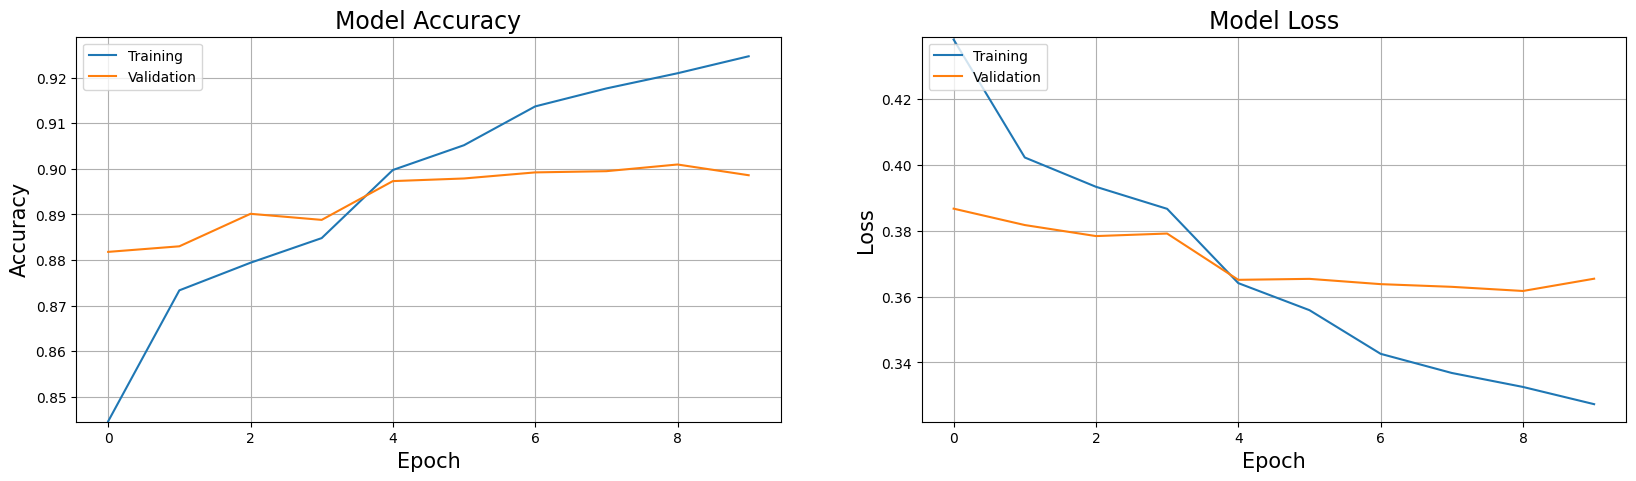

In [ ]:
#Accuracy and loss during training plot model1

def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(0.8445, 0.929)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(0.322, 0.439)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

plot_performance(history=history1)

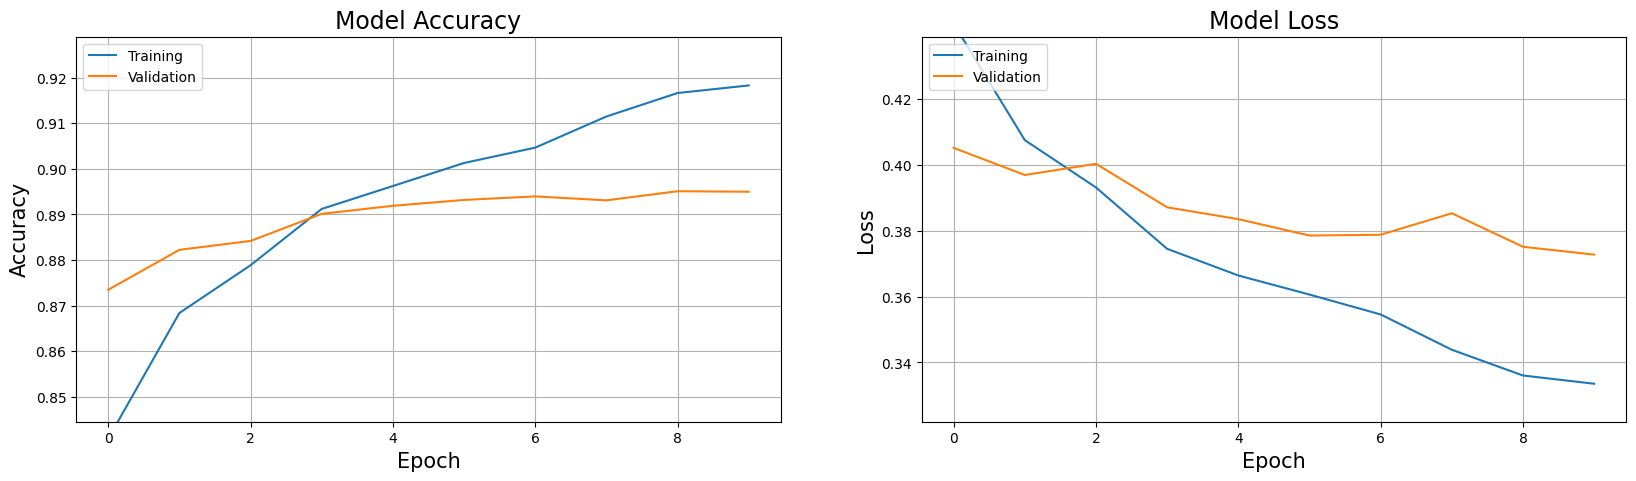

In [ ]:
#Accuracy and loss during training plot model2

def plot_performance(history=None, figure_directory=None):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(0.8445, 0.929)  # Set the y-axis limits for accuracy
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(0.322, 0.439)  # Set the y-axis limits for loss
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory + "/history")

    plt.show()

plot_performance(history=history2)
